In [242]:
import os
import openai
import numpy as np
import pandas as pd
from tqdm import tqdm
from openai import OpenAI
from pymilvus import Collection, CollectionSchema, FieldSchema, DataType, connections
from pymilvus import connections, utility
from langchain_openai import OpenAIEmbeddings
from langchain import text_splitter 
from langchain_community.vectorstores import Milvus
from langchain_community.retrievers.milvus import MilvusRetriever
from langchain.text_splitter import RecursiveCharacterTextSplitter

from transformers import AutoTokenizer, AutoModel

# 실험환경

In [342]:
# 임베딩 모델이름
company = 'OPENAI'
embedding_models = 'text-embedding-3-large'
header_include = True
table_include = True
split_yn = False
documnet_name = "IONIQ5_2024"

In [343]:
exp_name = f"{company}_{embedding_models}_h{header_include}_t{table_include}_s{split_yn}"
exp_dir = '../result/' + exp_name

os.makedirs(exp_dir, exist_ok=True)

In [344]:
DOC_DATA_DIR = '../../../pdf_parsing/parse_result/'
DOC_DATA_PATH =  DOC_DATA_DIR + 'doc_ioniq5_result.parquet'
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']

tqdm.pandas()

In [345]:
df = pd.read_parquet(DOC_DATA_PATH)

# Chunking

In [346]:
df['embedding_contents'] = df['doc_contents'] + '\n' + \
    df['table_contents'].apply(lambda x: '' if x is None else '\n'.join(x))

In [347]:
def text(x):
    
    img_urls = x['img_urls'].dropna()
    if len(img_urls)==0:
        img_urls = []
    else:
        img_urls = img_urls.tolist()[0]
        img_urls = [img_url for img_url in img_urls]
        
    tbl_contents = x['table_contents'].dropna()
    if len(tbl_contents)==0:
        tbl_contents = []
    else:
        tbl_contents = tbl_contents.tolist()[0]
        tbl_contents = [tbl_contents for tbl_contents in tbl_contents]
        
    tbl_img_urls = x['table_img_urls'].dropna()
    if len(tbl_img_urls)==0:
        tbl_img_urls = []
    else:
        tbl_img_urls = tbl_img_urls.tolist()[0]
        tbl_img_urls = [tbl_img_url for tbl_img_url in tbl_img_urls]
        
    block_nums = x['block_num'].dropna()
    if len(block_nums)==0:
        block_nums = []
    else:
        block_nums = block_nums.tolist()
        block_nums = [block_num for block_num in block_nums]
        
    embedding_contents = x['embedding_contents'].dropna()
    
    embedding_contents = embedding_contents.tolist()
    embedding_contents = '\n\n'.join(embedding_contents)
    
    doc_contents = x['doc_contents'].dropna()
    
    doc_contents = doc_contents.tolist()
    doc_contents = '\n\n'.join(doc_contents)
        
    return pd.Series({'img_urls':img_urls, 'table_contents': tbl_contents, 'table_img_urls':tbl_img_urls, 'block_num':block_nums, 'embedding_contents':embedding_contents, 'doc_contents':doc_contents})

In [348]:
df_h3 = df.groupby(['h1','h2','h3']).apply(lambda x: text(x)).reset_index()

In [349]:
# df_h3['embedding_contents'] = \
#     df_h3['h3'] + '\n' + \
#     df_h3['embedding_contents']
    
df_h3['doc_contents'] = \
    df_h3['h3'] + '\n' + \
    df_h3['doc_contents']

In [350]:
df_h3['contents_size'] = df_h3['doc_contents'].apply(len)

<Axes: ylabel='Frequency'>

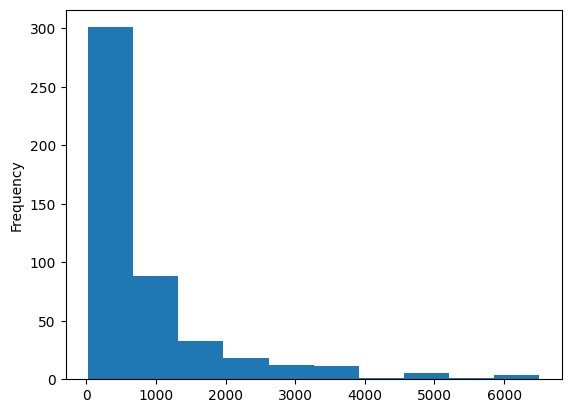

In [351]:
df_h3['contents_size'].plot.hist()

## Parent-Child Cunking

In [352]:
child_text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=500,
    chunk_overlap=50,
    length_function=len,
    is_separator_regex=False,
)

In [353]:

df_h3['child_embedding_chunk'] = df_h3['embedding_contents'].apply(lambda contents: list(map(lambda x: x.page_content, child_text_splitter.create_documents([contents]))))

In [354]:
df_h3 = df_h3.reset_index(names='doc_id')
df_h3 = df_h3.explode('child_embedding_chunk')

In [355]:
df_h3 = df_h3.reset_index(drop=True)

In [356]:
df_h3

,doc_id,h1,h2,h3,img_urls,table_contents,table_img_urls,block_num,embedding_contents,doc_contents,contents_size,child_embedding_chunk
0,0,1. 안내 및 차량 정보,구동 모터 번호,,"[./image/ioniq5_2024/76_9_img.png, ./image/ion...",[],[],[76_7],구동 모터 번호 \n2WD / 4WD\n4WD\n구동 모터 번호는 차량 밑에서 확인...,\n구동 모터 번호 \n2WD / 4WD\n4WD\n구동 모터 번호는 차량 밑에서 ...,54,구동 모터 번호 \n2WD / 4WD\n4WD\n구동 모터 번호는 차량 밑에서 확인...
1,1,1. 안내 및 차량 정보,모터룸,,[./image/ioniq5_2024/70_1_img.png],[],[],[70_0],모터룸\n이 그림은 실제 차량과 다를 수 있습니다.\n,\n모터룸\n이 그림은 실제 차량과 다를 수 있습니다.,28,모터룸\n이 그림은 실제 차량과 다를 수 있습니다.
2,2,1. 안내 및 차량 정보,에어컨 시스템,,[],[| | 에어컨 시스템 | 에어컨 시스템 | 에어컨 시스템 |\n|...,[./image/ioniq5_2024/73_1_table.jpeg],[73_9],"에어컨 시스템\n에어컨 관련 작업 시, 반드시 지정된 냉매를 사용하십시오.지정되지 ...","\n에어컨 시스템\n에어컨 관련 작업 시, 반드시 지정된 냉매를 사용하십시오.지정되...",92,"에어컨 시스템\n에어컨 관련 작업 시, 반드시 지정된 냉매를 사용하십시오.지정되지 ..."
3,3,1. 안내 및 차량 정보,자기 인증 라벨,,[./image/ioniq5_2024/76_5_img.jpeg],[],[],[76_4],자기 인증 라벨\n자기 인증 라벨은 차량이 대한민국 자동차 관리법령에 맞게 제작되었...,\n자기 인증 라벨\n자기 인증 라벨은 차량이 대한민국 자동차 관리법령에 맞게 제작...,55,자기 인증 라벨\n자기 인증 라벨은 차량이 대한민국 자동차 관리법령에 맞게 제작되었...
4,4,1. 안내 및 차량 정보,전구의 용량,,[],[| | 전구의 용량 | 전구의 용량 ...,[./image/ioniq5_2024/74_0_table.jpeg],[74_0],전구의 용량\nLED(Light-Emitting Diode): 발광소자\n| ...,\n전구의 용량\nLED(Light-Emitting Diode): 발광소자,39,전구의 용량\nLED(Light-Emitting Diode): 발광소자\n| ...
...,...,...,...,...,...,...,...,...,...,...,...,...
1405,471,전기차 시작하기,전기 자동차 충전 표시등,충전 상태 표시등,[./image/ioniq5_2024/23_4_img.png],[| | 충전 표시등 동작 | 충전량[%] |\n|---:|:-----...,[./image/ioniq5_2024/23_1_table.jpeg],"[23_3, 23_15]",충전 도어\n| | 충전 표시등 동작 | 충전량[%] |\n|---:|...,충전 상태 표시등\n충전 도어\n\n전면 범퍼 중앙,25,전면 범퍼 중앙\n| | 충전 표시등 동작 | 충전량[%] |\n|--...
1406,472,전기차 시작하기,충전 커넥터 잠금,완속 충전 시 충전 커넥터 잠금 모드,[./image/ioniq5_2024/24_2_img.png],[| | 커넥터 잠금 | 동작 | 동작 | 동작 |...,[./image/ioniq5_2024/24_0_table.jpeg],"[24_1, 24_7]",완속 충전 시 충전 커넥터 잠금 모드\n충전 커넥터를 잠금하는 기능으로 외부인이 충...,완속 충전 시 충전 커넥터 잠금 모드\n완속 충전 시 충전 커넥터 잠금 모드\n충전...,824,완속 충전 시 충전 커넥터 잠금 모드\n충전 커넥터를 잠금하는 기능으로 외부인이 충...
1407,472,전기차 시작하기,충전 커넥터 잠금,완속 충전 시 충전 커넥터 잠금 모드,[./image/ioniq5_2024/24_2_img.png],[| | 커넥터 잠금 | 동작 | 동작 | 동작 |...,[./image/ioniq5_2024/24_0_table.jpeg],"[24_1, 24_7]",완속 충전 시 충전 커넥터 잠금 모드\n충전 커넥터를 잠금하는 기능으로 외부인이 충...,완속 충전 시 충전 커넥터 잠금 모드\n완속 충전 시 충전 커넥터 잠금 모드\n충전...,824,커넥터 잠금 동작\n 상시 잠금: 충전 커넥터를 충전 인렛에 연결하면 잠금장치가 잠...
1408,472,전기차 시작하기,충전 커넥터 잠금,완속 충전 시 충전 커넥터 잠금 모드,[./image/ioniq5_2024/24_2_img.png],[| | 커넥터 잠금 | 동작 | 동작 | 동작 |...,[./image/ioniq5_2024/24_0_table.jpeg],"[24_1, 24_7]",완속 충전 시 충전 커넥터 잠금 모드\n충전 커넥터를 잠금하는 기능으로 외부인이 충...,완속 충전 시 충전 커넥터 잠금 모드\n완속 충전 시 충전 커넥터 잠금 모드\n충전...,824,| | 커넥터 잠금 | 동작 | 동작 | 동작 |\...


# BS25

In [357]:
df = df_h3

In [358]:
from konlpy.tag import Mecab
mecab = Mecab()

In [359]:
def tokenizer(text):
    pos_tag = mecab.pos(text)
    pos_tag = list(filter(lambda x: x[1] in ['NNG', 'NNP', 'SL'], pos_tag))
    pos_tag = list(map(lambda x: x[0], pos_tag))
    return pos_tag

In [360]:
df['noun_token'] = df['child_embedding_chunk'].apply(tokenizer)

In [361]:
from rank_bm25 import BM25Okapi

In [362]:
bm25 = BM25Okapi(df['noun_token'].values.tolist())

In [363]:
query = "스티어링휠 조정 방법"
tokenized_query = tokenizer(query)

doc_scores = bm25.get_scores(tokenized_query)
doc_scores

array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       2.63627612])

In [364]:
print(df.loc[doc_scores.argsort(), 'child_embedding_chunk'].tail().values)

['눈길, 빙판길 주행 시 주의 사항 가속 페달을 서서히 밟아 부드럽게 출발하십시오. 타이어 체인이나 스노우 타이어를 사용하십시오. 차간 거리를 충분히 유지하십시오. 주행 중 급가속, 급제동, 과도한 스티어링 휠조작을 하지 마십시오. 차량이 미끄러질 수있어 위험합니다. 내리막길에서 회생 제동(패들 쉬프트 왼쪽레버로 회생 제동량 증대)을 사용하면 방향조작에 도움이 됩니다. 단, 회생 제동을 이용한 타력 주행 중에는 차량 조정이 어려울 수있으므로, 회생 제동 3단계 사용은 가급적 자제하여 주십시오. 오르막길에서는 한 번 멈추면 다시 출발하기가 어렵습니다. 다른 차량과의 거리를 유지하고 서행하십시오.'
 '스마트 키의 감지 거리는 주변 환경(송전탑,방송국과 같이 전파의 영향이 강한 지역 등)에 따라 달라질 수 있습니다. 방법 (1)로 원격 전진하는 경우 출차 상황으로 판단하여 주변 사람, 동물 또는 물체를 확인한 (약 4m 이동) 후 전방 상황에 따라 스티어링 휠 제어를 합니다. 방법 (2)로 원격 전진하는 경우 주차 상황으로 판단하여 전방 상황에 따라 스티어링 휠제어를 하여 주차공간 진입 및 차량 정렬을보조합니다.  원격 후진하는 경우, 방법 (1), (2) 모두 스티어링 휠을 정렬한 후 차량이 직진으로만 이동합니다. 원격 전/후진 기능을 완료하면 자동으로「P」 (주차)단으로 변속하고 전자식 파킹 브레이크(EPB)를 체결합니다.'
 '사륜구동 차량의 운전 요령\n사륜구동 차량의 특징을 잘 이해하고 도로 조건에 맞게 주행하십시오. 위험하다고 판단되는길은 주행하지 마십시오.\n\n\n일반 주의 사항 반드시 안전벨트를 착용하십시오. 운전할 때 자세를 평상시보다 스티어링 휠과가깝게 하고 곧은 자세를 유지하십시오. 스티어링 휠이나 페달을 손쉽게 조작할 수 있도록 여유 있는 위치로 조정하십시오. 비포장 험로를 주행할 경우 차량의 지상고가낮아 차체 손상이 발생할 수 있습니다. 위험한 지역을 피해 주행하십시오. 사륜구동 차량도 일반 차량과 마찬가지로 조향 및 브레이크 조작을 신

# Embedding

In [365]:
df

,doc_id,h1,h2,h3,img_urls,table_contents,table_img_urls,block_num,embedding_contents,doc_contents,contents_size,child_embedding_chunk,noun_token
0,0,1. 안내 및 차량 정보,구동 모터 번호,,"[./image/ioniq5_2024/76_9_img.png, ./image/ion...",[],[],[76_7],구동 모터 번호 \n2WD / 4WD\n4WD\n구동 모터 번호는 차량 밑에서 확인...,\n구동 모터 번호 \n2WD / 4WD\n4WD\n구동 모터 번호는 차량 밑에서 ...,54,구동 모터 번호 \n2WD / 4WD\n4WD\n구동 모터 번호는 차량 밑에서 확인...,"[구동, 모터, 번호, WD, WD, WD, 구동, 모터, 번호, 차량, 밑, 확인]"
1,1,1. 안내 및 차량 정보,모터룸,,[./image/ioniq5_2024/70_1_img.png],[],[],[70_0],모터룸\n이 그림은 실제 차량과 다를 수 있습니다.\n,\n모터룸\n이 그림은 실제 차량과 다를 수 있습니다.,28,모터룸\n이 그림은 실제 차량과 다를 수 있습니다.,"[모터, 룸, 그림, 실제, 차량]"
2,2,1. 안내 및 차량 정보,에어컨 시스템,,[],[| | 에어컨 시스템 | 에어컨 시스템 | 에어컨 시스템 |\n|...,[./image/ioniq5_2024/73_1_table.jpeg],[73_9],"에어컨 시스템\n에어컨 관련 작업 시, 반드시 지정된 냉매를 사용하십시오.지정되지 ...","\n에어컨 시스템\n에어컨 관련 작업 시, 반드시 지정된 냉매를 사용하십시오.지정되...",92,"에어컨 시스템\n에어컨 관련 작업 시, 반드시 지정된 냉매를 사용하십시오.지정되지 ...","[에어컨, 시스템, 에어컨, 관련, 작업, 지정, 냉매, 사용, 지정, 냉매, 사용..."
3,3,1. 안내 및 차량 정보,자기 인증 라벨,,[./image/ioniq5_2024/76_5_img.jpeg],[],[],[76_4],자기 인증 라벨\n자기 인증 라벨은 차량이 대한민국 자동차 관리법령에 맞게 제작되었...,\n자기 인증 라벨\n자기 인증 라벨은 차량이 대한민국 자동차 관리법령에 맞게 제작...,55,자기 인증 라벨\n자기 인증 라벨은 차량이 대한민국 자동차 관리법령에 맞게 제작되었...,"[인증, 라벨, 인증, 라벨, 차량, 대한민국, 자동차, 관리, 법령, 제작]"
4,4,1. 안내 및 차량 정보,전구의 용량,,[],[| | 전구의 용량 | 전구의 용량 ...,[./image/ioniq5_2024/74_0_table.jpeg],[74_0],전구의 용량\nLED(Light-Emitting Diode): 발광소자\n| ...,\n전구의 용량\nLED(Light-Emitting Diode): 발광소자,39,전구의 용량\nLED(Light-Emitting Diode): 발광소자\n| ...,"[전구, 용량, LED, Light, Emitting, Diode, 발광, 소자, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405,471,전기차 시작하기,전기 자동차 충전 표시등,충전 상태 표시등,[./image/ioniq5_2024/23_4_img.png],[| | 충전 표시등 동작 | 충전량[%] |\n|---:|:-----...,[./image/ioniq5_2024/23_1_table.jpeg],"[23_3, 23_15]",충전 도어\n| | 충전 표시등 동작 | 충전량[%] |\n|---:|...,충전 상태 표시등\n충전 도어\n\n전면 범퍼 중앙,25,전면 범퍼 중앙\n| | 충전 표시등 동작 | 충전량[%] |\n|--...,"[전면, 범퍼, 중앙, 충전, 표시, 동작, 충전, 량]"
1406,472,전기차 시작하기,충전 커넥터 잠금,완속 충전 시 충전 커넥터 잠금 모드,[./image/ioniq5_2024/24_2_img.png],[| | 커넥터 잠금 | 동작 | 동작 | 동작 |...,[./image/ioniq5_2024/24_0_table.jpeg],"[24_1, 24_7]",완속 충전 시 충전 커넥터 잠금 모드\n충전 커넥터를 잠금하는 기능으로 외부인이 충...,완속 충전 시 충전 커넥터 잠금 모드\n완속 충전 시 충전 커넥터 잠금 모드\n충전...,824,완속 충전 시 충전 커넥터 잠금 모드\n충전 커넥터를 잠금하는 기능으로 외부인이 충...,"[완, 속, 충전, 충전, 커넥터, 모드, 충전, 커넥터, 기능, 외부, 충전, 커..."
1407,472,전기차 시작하기,충전 커넥터 잠금,완속 충전 시 충전 커넥터 잠금 모드,[./image/ioniq5_2024/24_2_img.png],[| | 커넥터 잠금 | 동작 | 동작 | 동작 |...,[./image/ioniq5_2024/24_0_table.jpeg],"[24_1, 24_7]",완속 충전 시 충전 커넥터 잠금 모드\n충전 커넥터를 잠금하는 기능으로 외부인이 충...,완속 충전 시 충전 커넥터 잠금 모드\n완속 충전 시 충전 커넥터 잠금 모드\n충전...,824,커넥터 잠금 동작\n 상시 잠금: 충전 커넥터를 충전 인렛에 연결하면 잠금장치가 잠...,"[커넥터, 동작, 상시, 충전, 커넥터, 충전, 렛, 연결, 잠금장치, 사용, 해제..."
1408,472,전기차 시작하기,충전 커넥터 잠금,완속 충전 시 충전 커넥터 잠금 모드,[./image/ioniq5_2024/24_2_img.png],[| | 커넥터 잠금 | 동작 | 동작 | 동작 |...,[./image/ioniq5_2024/24_0_table.jpeg],"[24_1, 24_7]",완속 충전 시 충전 커넥터 잠금 모드\n충전 커넥터를 잠금하는 기능으로 외부인이 충...,완속 충전 시 충전 커넥터 잠금 모드\n완속 충전 시 충전 커넥터 잠금 모드\n충전...,824,| | 커넥터 잠금 | 동작 | 동작 | 동작 |\...,"[커넥터, 동작, 동작, 동작, 상시, 충전, 사용, 안함, 충전, 전, O, X,..."


In [366]:
client = OpenAI(api_key=OPENAI_API_KEY)

In [367]:
global tokens

tokens=0


def get_embedding(text):
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=text
    )
    global tokens
    tokens = tokens + response.usage.total_tokens
    # print(index)
    return response.data[0].embedding

In [368]:
df['child_embedding_chunk'] = \
    df['h3'].fillna('') + '\n' + \
    df['child_embedding_chunk']

In [369]:
embedding_result = df['child_embedding_chunk'].progress_apply(lambda x: get_embedding(x))

100%|██████████| 1410/1410 [15:06<00:00,  1.56it/s]


In [372]:
print(f"TOKEN USAGE: {tokens}")
print(f"PRICE USAGE: {(tokens/1024/1024)*0.02*1350}원")

TOKEN USAGE: 421504
PRICE USAGE: 10.8533935546875원


In [373]:
df['embeddings'] = embedding_result

## Embedding 결과 저장

In [374]:
embedding_result_path = exp_dir + '/embeddings_pc_chunking.parquet'
df.to_parquet(embedding_result_path, index=False)

# Vector DB 저장

In [375]:
MILVUS_HOST = os.environ['MILVUS_HOST']
MILVUS_PORT = os.environ['MILVUS_PORT']
COLLECTION_NAME = "IONIQ5_2024"
connections.connect(alias="default", host=MILVUS_HOST, port=MILVUS_PORT)

In [376]:
embedding_result_path = exp_dir + '/embeddings_pc_chunking.parquet'
df = pd.read_parquet(embedding_result_path)

## Document 내 header 제외

**내용이 없기 때문**

In [377]:
df['car_type'] = documnet_name

**Collection 삭제 예시**

In [382]:
utility.drop_collection(COLLECTION_NAME)

In [383]:
df.head(1)

,index,doc_id,h1,h2,h3,img_urls,table_contents,table_img_urls,block_num,embedding_contents,doc_contents,contents_size,child_embedding_chunk,noun_token,embeddings,car_type
0,0,0,1. 안내 및 차량 정보,구동 모터 번호,,"[./image/ioniq5_2024/76_9_img.png, ./image/ion...",[],[],[76_7],구동 모터 번호 \n2WD / 4WD\n4WD\n구동 모터 번호는 차량 밑에서 확인...,\n구동 모터 번호 \n2WD / 4WD\n4WD\n구동 모터 번호는 차량 밑에서 ...,54,\n구동 모터 번호 \n2WD / 4WD\n4WD\n구동 모터 번호는 차량 밑에서 ...,"[구동, 모터, 번호, WD, WD, WD, 구동, 모터, 번호, 차량, 밑, 확인]","[-0.008841953240334988, 0.009490522556006908, ...",IONIQ5_2024


## Collection 생성

In [384]:
id_field = FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=False)
car_type_filed = FieldSchema(name="car_type", dtype=DataType.VARCHAR, max_length=100, is_primary=False, auto_id=False,
                           description='차종')
major_h_filed = FieldSchema(name="majorheading", dtype=DataType.VARCHAR, max_length=100, is_primary=False, auto_id=False,
                           description='설명서의 대제목')
sub_h_filed = FieldSchema(name="subheading", dtype=DataType.VARCHAR, max_length=100, is_primary=False, auto_id=False,
                         description='설명서의 중제목')
minor_h_filed = FieldSchema(name="minorheading", dtype=DataType.VARCHAR, max_length=100, is_primary=False, auto_id=False,
                           description='설명서의 소제목')


imgurl_filed = FieldSchema(name="img_urls", dtype=DataType.ARRAY, element_type=DataType.VARCHAR, max_capacity=20, max_length=50,
                            description='이미지 URL 경로')
tblimgurl_field = FieldSchema(name="tbl_img_urls", dtype=DataType.ARRAY, element_type=DataType.VARCHAR, max_capacity=20, max_length=50,
                            description='표 이미지 URL 경로')
tbl_contents_filed = FieldSchema(name="tbl_contents", dtype=DataType.ARRAY, element_type=DataType.VARCHAR, max_capacity=20, max_length=3000,
                            description='표 내용')

noun_token_filed = FieldSchema(name="noun_tokens", dtype=DataType.ARRAY, element_type=DataType.VARCHAR, max_capacity=500, max_length=100,
                            description='표 이미지 URL 경로')
embedding_contents_filed = FieldSchema(name="embedding_contents", dtype=DataType.VARCHAR, max_length=20000, is_primary=False, auto_id=False,
                            description='검증용 임베딩 내용')
parent_contents_filed = FieldSchema(name="doc_contents", dtype=DataType.VARCHAR, max_length=20000, is_primary=False, auto_id=False,
                            description='검증용 Parent 설명서의 내용')
doc_id_filed = FieldSchema(name="doc_id", dtype=DataType.INT64, max_length=20000, is_primary=False, auto_id=False,
                            description='Parent 문서 ID')
vector_filed = FieldSchema(name="vector", dtype=DataType.FLOAT_VECTOR, dim=3072)
# 컬렉션 스키마 정의
schema = CollectionSchema(
    fields=[
        id_field, 
        car_type_filed,
        major_h_filed,
        sub_h_filed,
        minor_h_filed,
        imgurl_filed,
        tblimgurl_field,
        tbl_contents_filed,
        noun_token_filed,
        embedding_contents_filed,
        parent_contents_filed,
        doc_id_filed,
        vector_filed],
    description="2024 아이오닉5 문서"
)

# 컬렉션 생성
if COLLECTION_NAME not in utility.list_collections():
    collection = Collection(name=COLLECTION_NAME, schema=schema)
else:
    collection = Collection(name=COLLECTION_NAME)



## Data 적재

In [385]:
#Index 생성
df = df.reset_index(drop=True).reset_index()

# Pandas DataFrame에서 데이터 추출 및 Milvus에 삽입
ids = df['index'].to_list()
car_types = df['car_type'].to_list()
h1s = df['h1'].to_list()
h2s = df['h2'].fillna('').astype(str).to_list()
h3s = df['h3'].fillna('').astype(str).to_list()
img_urls = df['img_urls'].to_list()
table_img_urls = df['table_img_urls'].to_list()
table_contents = df['table_contents'].to_list()
noun_token = df['noun_token'].to_list()
embedding_cont = df['child_embedding_chunk'].to_list()
cons = df['doc_contents'].to_list()
doc_id = df['doc_id'].to_list()
vectors = df['embeddings'].to_list()

In [236]:
if COLLECTION_NAME not in utility.list_collections():
    mr = collection.insert([ids, car_types, h1s, h2s, h3s, img_urls, table_img_urls, table_contents, noun_token, embedding_cont, cons, doc_id, vectors])

## Index 생성

<Axes: ylabel='Frequency'>

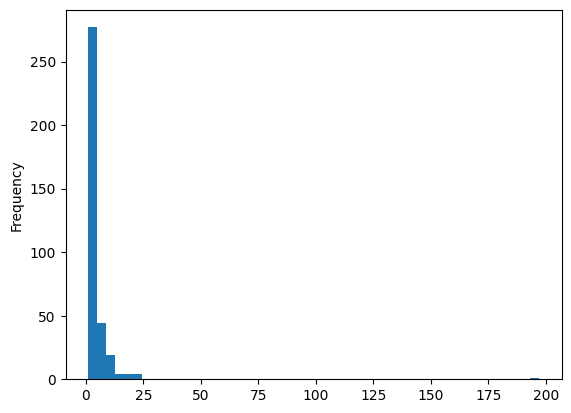

In [387]:
df.groupby('h3').size().plot.hist(bins=50)

In [519]:
M = 20
efConstruction=30

In [520]:
collection.release()
collection.drop_index()

In [521]:
collection.create_index(
    field_name="vector", 
    index_params={
        "index_type": "HNSW", 
        "metric_type": "COSINE", 
        "params": {"M": M, 'efConstruction':efConstruction} # Cluster 개수
        }
)

# collection.create_index(
#     field_name="vector", 
#     index_params={
#         "index_type": "IVF_FLAT", 
#         "metric_type": "COSINE", 
#         "params": {"nlist": df['h2'].nunique()} # Cluster 개수
#         }
# )

Status(code=0, message=)

In [522]:
collection = Collection(documnet_name)
collection.load()

# Evaluation

## 평가 데이터 불러오기

In [484]:
df = pd.read_parquet("/Users/yj/Kim/3.study/5.GenAI/my-small-mechanic/embeddings/evaluation_dataset/evaluation_qaset_240429_gpt35-turbo.parquet")

In [485]:
client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])

In [523]:
topK = 3
ef = 30
SEARCH_PARAM = {
    "index_type": "HNSW", "metric_type": "COSINE", "params": {"ef": ef}
}

def get_embedding(text):
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=text
    )
    return response.data[0].embedding

def embed_search(search_string):
    search_embeddings = get_embedding(search_string)#['vectors'][0].tolist()
    return search_embeddings


def search_doc(query, topK=3):
    user_vector = embed_search(query)
    results = collection.search([user_vector],"vector",param=SEARCH_PARAM, limit=topK, expr=None, 
                             output_fields=['majorheading', 'subheading', 'minorheading', 'doc_contents', 'img_urls', 'tbl_img_urls', 'tbl_contents', 'doc_id', 'embedding_contents'])

    search_dict = {}
    
    for i, result in enumerate(results[0]):
        doc_entity = result.entity
        doc = {
            'distance': result.distance,
            'majorheading': doc_entity.get('majorheading'),
            'subheading': doc_entity.get('subheading'),
            'minorheading': doc_entity.get('minorheading'),
            'doc_contents': doc_entity.get('doc_contents'),
            'img_urls': doc_entity.get('img_urls'),
            'tbl_img_urls': doc_entity.get('tbl_img_urls'),
            'tbl_contents': doc_entity.get('tbl_contents'),
            'doc_id': doc_entity.get('doc_id'),
            'embedding_contents': doc_entity.get('embedding_contents'),
            
        }
        search_dict[i] = doc
    return search_dict

## 평가

In [524]:
qaset = df[['doc_id', 'doc_contents', '질문', '대답']].copy()

In [525]:
qaset['doc1'] = np.nan
qaset['doc2'] = np.nan
qaset['doc3'] = np.nan
qaset['doc4'] = np.nan
qaset['doc5'] = np.nan


In [526]:
topK=5

In [528]:
for i, row in tqdm(qaset[qaset['doc1'].isna()].iterrows()):
    query = row['질문']
    quert_result = search_doc(query, topK)
    for k, v in quert_result.items():
        columns = f"doc{k+1}"
        qaset.loc[i, columns] = v['doc_id']
        
    # if i==10:
    #     break

751it [06:09,  2.03it/s]


In [277]:
qaset.to_parquet(f'../result/{exp_name}/prediection_240429_gpt35_xmlcontext.parquet', index=False)

In [78]:
sample_qaset = qaset.loc[0:99].copy()

## Top 1 정확도

In [491]:
qaset = pd.read_parquet(f'../result/{exp_name}/prediection_240429_gpt35_xmlcontext.parquet')

In [492]:
qaset

,doc_id,doc_contents,질문,대답,doc1,doc2,doc3,doc4,doc5
0,0,\n구동 모터 번호 \n2WD / 4WD\n4WD\n구동 모터 번호는 차량 밑에서 ...,구동 모터 번호는 어디에서 확인할 수 있나요?,구동 모터 번호는 차량 밑에서 확인할 수 있습니다.,0.0,5.0,214.0,214.0,214.0
1,1,\n모터룸\n이 그림은 실제 차량과 다를 수 있습니다.,모터룸에 대해 어떤 내용이 포함되어 있나요?,모터룸에 대한 그림은 실제 차량과 다를 수 있다고 언급되어 있습니다.,1.0,395.0,19.0,429.0,416.0
2,2,"\n에어컨 시스템\n에어컨 관련 작업 시, 반드시 지정된 냉매를 사용하십시오.지정되...",에어컨 시스템 작업 시 지정된 냉매를 사용해야 하는 이유는 무엇인가요?,지정되지 않은 냉매를 사용하면 냉방 성능이 저하되고 심각한 부품 손상이 발생할 수 ...,2.0,227.0,227.0,227.0,226.0
3,2,"\n에어컨 시스템\n에어컨 관련 작업 시, 반드시 지정된 냉매를 사용하십시오.지정되...",에어컨 시스템에서 사용되는 에어컨 냉매의 용량은 얼마인가요?,에어컨 냉매의 용량은 900g±25입니다.,2.0,227.0,227.0,227.0,416.0
4,2,"\n에어컨 시스템\n에어컨 관련 작업 시, 반드시 지정된 냉매를 사용하십시오.지정되...",에어컨 시스템에 사용되는 냉동유의 용량은 얼마인가요?,냉동유의 용량은 180±10입니다.,2.0,227.0,227.0,416.0,416.0
...,...,...,...,...,...,...,...,...,...
1319,472,완속 충전 시 충전 커넥터 잠금 모드\n완속 충전 시 충전 커넥터 잠금 모드\n충전...,완속 충전 시 충전 커넥터 잠금 모드는 어떤 기능을 하는 건가요?,완속 충전 시 충전 커넥터 잠금 모드는 외부인이 충전 커넥터를 충전 인렛으로부터 분...,472.0,472.0,472.0,461.0,461.0
1320,472,완속 충전 시 충전 커넥터 잠금 모드\n완속 충전 시 충전 커넥터 잠금 모드\n충전...,충전 커넥터 잠금을 해제하려면 어떤 작업을 해야 하나요?,충전 커넥터 잠금을 해제하기 위해서는 차량 도어 잠금을 해제해야 합니다.,472.0,472.0,461.0,460.0,472.0
1321,472,완속 충전 시 충전 커넥터 잠금 모드\n완속 충전 시 충전 커넥터 잠금 모드\n충전...,충전 중에 도어를 잠그면 어떻게 되나요?,충전 중에 도어를 잠그면 충전 커넥터도 즉시 다시 잠기게 됩니다.,463.0,178.0,463.0,178.0,461.0
1322,473,\n충전이 시작되지 않은 경우 확인사항\n충전기를 차량에 연결한 후 충전이 시작되지...,충전이 시작되지 않은 경우 어떤 확인사항을 해야 하나요?,"충전이 시작되지 않는 경우 예약 충전 설정, 충전기의 작동 상태, 클러스터에 표시된...",473.0,469.0,466.0,469.0,73.0


In [529]:
len(qaset[qaset['doc_id']==qaset['doc1']])/len(qaset)

0.6608761329305136

Top 2 정확도

In [530]:
qaset[['doc_id', 'doc1', 'doc2']].apply(lambda x: x[0] in x[1:3].values, axis=1).sum()/len(qaset)

0.7726586102719033

Top 3 정확도

In [531]:
qaset[['doc_id', 'doc1', 'doc2', 'doc3']].apply(lambda x: x[0] in x[1:4].values, axis=1).sum()/len(qaset)

0.8066465256797583

Top 5 정확도

In [532]:
qaset[['doc_id', 'doc1', 'doc2', 'doc3', 'doc4','doc5']].apply(lambda x: x[0] in x[1:6].values, axis=1).sum()/len(qaset)

0.8534743202416919

# Reranker 적용

In [286]:
import torch
import numpy as np

In [436]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("Dongjin-kr/ko-reranker")
model = AutoModelForSequenceClassification.from_pretrained("Dongjin-kr/ko-reranker")

In [437]:
def exp_normalize(x):
    b = x.max()
    y = np.exp(x - b)
    return y / y.sum()

In [438]:
# qaset_rr['doc1'] = np.nan
# qaset_rr['doc2'] = np.nan
# qaset_rr['doc3'] = np.nan
# qaset_rr['doc4'] = np.nan
# qaset_rr['doc5'] = np.nan

qaset['rr_doc1'] = np.nan
qaset['rr_doc2'] = np.nan
qaset['rr_doc3'] = np.nan
qaset['rr_doc4'] = np.nan
qaset['rr_doc5'] = np.nan


In [439]:
from collections import OrderedDict

In [440]:
torch.set_default_device("cpu")

In [459]:
topK = 5

In [471]:
for i, row in tqdm(qaset[qaset['rr_doc1'].isna()].iterrows()):
    query = row['질문']
    query_result = search_doc(query, topK)
    query_result = OrderedDict(sorted(query_result.items(), key=lambda x: x[0], reverse=False))
    pairs = list(map(lambda k: [k[0],k[1][1]['embedding_contents']], zip([query]*len(query_result), query_result.items())))
    doc_ids = list(map(lambda x: x[1]['doc_id'], query_result.items()))
    # qaset_rr.loc[i, ['doc1', 'doc2', 'doc3', 'doc4', 'doc5']] = np.array(doc_ids)
    with torch.no_grad():
        inputs = tokenizer(pairs, padding=True, truncation=True, return_tensors='pt', max_length=512)
        scores = model(**inputs, return_dict=True).logits.view(-1, ).float()
        scores = exp_normalize(scores.numpy())
        
        qaset.loc[i, ['rr_doc1', 'rr_doc2', 'rr_doc3', 'rr_doc4', 'rr_doc5']] = np.array(doc_ids)[np.argsort(scores)][::-1]


1122it [45:23,  2.43s/it]


In [472]:
qaset.to_parquet('reranker_gpt35_xmlcontext.paruqet', index=False)

In [493]:
qaset = pd.read_parquet('reranker_gpt35_xmlcontext.paruqet')

In [534]:
sample_qaset_rr = qaset[~qaset['doc1'].isna()].copy()
sample_datasize = len(sample_qaset_rr)

## Hit Rate

In [474]:
print(len(sample_qaset_rr[sample_qaset_rr['doc_id']==sample_qaset_rr['doc1']])/sample_datasize)
print(len(sample_qaset_rr[sample_qaset_rr['doc_id']==sample_qaset_rr['rr_doc1']])/sample_datasize)

0.6299093655589124
0.7077039274924471


In [475]:
print(sample_qaset_rr[['doc_id', 'doc1', 'doc2']].apply(lambda x: x[0] in x[1:3].values, axis=1).sum()/sample_datasize)
print(sample_qaset_rr[['doc_id', 'rr_doc1', 'rr_doc2']].apply(lambda x: x[0] in x[1:3].values, axis=1).sum()/sample_datasize)

0.7348942598187311
0.7620845921450151


In [476]:
print(sample_qaset_rr[['doc_id', 'doc1', 'doc2', 'doc3']].apply(lambda x: x[0] in x[1:4].values, axis=1).sum()/sample_datasize)
print(sample_qaset_rr[['doc_id', 'rr_doc1', 'rr_doc2', 'rr_doc3']].apply(lambda x: x[0] in x[1:4].values, axis=1).sum()/sample_datasize)

0.7688821752265861
0.7794561933534743


In [477]:
print(sample_qaset_rr[['doc_id', 'doc1', 'doc2', 'doc3', 'doc4','doc5']].apply(lambda x: x[0] in x[1:6].values, axis=1).sum()/sample_datasize)
print(sample_qaset_rr[['doc_id', 'rr_doc1', 'rr_doc2', 'rr_doc3', 'rr_doc4','rr_doc5']].apply(lambda x: x[0] in x[1:6].values, axis=1).sum()/sample_datasize)

0.8149546827794562
0.7915407854984894


## MRR

In [533]:
def get_mrr(x):
    x = x.values
    rank = np.where(x[1:6]==x[0])[0]
    if len(rank)>0:
        return 1/(rank[0] + 1)
    else:
        return 0

In [535]:
sample_qaset_rr['mrr'] = sample_qaset_rr[['doc_id', 'doc1', 'doc2', 'doc3', 'doc4','doc5']]\
        .apply(lambda x: get_mrr(x), axis=1)

# sample_qaset_rr['rr_mrr'] = sample_qaset_rr[['doc_id', 'rr_doc1', 'rr_doc2', 'rr_doc3', 'rr_doc4','rr_doc5']]\
#         .apply(lambda x: get_mrr(x), axis=1)

In [536]:
sample_qaset_rr['mrr'].mean()

0.7390861027190332

In [499]:
sample_qaset_rr['rr_mrr'].mean()

0.7434415911379658

In [538]:
for i, row in sample_qaset_rr[sample_qaset_rr['mrr']==0].iterrows():
    print(row['질문'], row['doc_id'], int(row['doc1']))

자기 인증 라벨이 차량에 부착되어 있는 이유는 무엇인가요? 3 431
휠 너트 체결토크가 왜 중요한가요? 9 427
타이어 사이즈가 동일해도 무엇이 다를 수 있나요? 11 423
스탠딩 웨이브 현상이란 무엇인가요? 15 135
브레이크 오일이 부족하거나 급격히 감소했을 때 어떻게 해아할까요? 19 398
냉각수량이 부족하거나 급격히 감소했을 때 어떻게 해아할까요? 19 394
냉각수의 양을 점검할 때 주의할 점은 무엇인가요? 19 394
어린이를 무릎에 앉히면 어떤 위험이 있을 수 있나요? 20 48
안전벨트를 착용하지 않고 충돌이 발생하면 어떤 위험을 감수해야 하나요? 23 43
동승석에 어린이용 보호장치를 설치하면 어떤 위험이 있을까요? 24 48
운전자의 헤드레스트 높이를 조절하는 이유는 무엇인가요? 25 65
음주운전이 왜 위험한가요? 27 261
약물을 복용한 후에는 어떻게 해야 하나요? 27 200
주차 브레이크를 푼 후에 어떤 절차를 거쳐야 하나요? 30 275
주행 중에는 무엇을 해야 하나요? 35 36
차량에 비인가 전기 장치를 임의로 장착하면 어떤 문제가 발생할 수 있나요? 37 42
어떤 옷을 입으면 시트원단을 오염시킬 수 있나요? 38 418
스티어링 휠을 비닐을 제거할 때 어떤 도구를 사용하면 안 되나요? 38 133
어린이와 함께 차량을 탈 때 주의해야 하는 사항은 무엇인가요? 40 22
어린이 보조 좌석이 왜 중요한가요? 44 48
동승석에 어린이 보조 좌석을 설치하면 어떻게 되나요? 52 48
에어백은 어떤 상황에서 충돌 및 전복 시 작동되나요? 57 59
어린이를 동승석에 어린이 보조 좌석을 설치하면 어떤 위험이 있나요? 57 48
에어백이 작동하는 상황 중 어떤 경우에는 에어백이 작동하지 않나요? 57 59
에어백이 작동할 때 어떤 상황을 피해야 하나요? 60 59
릴렉션 컴포트 시트를 사용할 때 주의해야 할 점은 무엇인가요? 66 200
인포테인먼트 시스템이 업데이트되면 어떤 점이 바뀌나요? 68 177
주행 가능 거리는 어떻

In [517]:
query_result = search_doc('어디에서 충전소를 검색할 수 있나요?', topK)

In [518]:
query_result

{0: {'distance': 0.561803936958313,
  'majorheading': '전기차 시작하기',
  'subheading': '전기 자동차 충전 종류',
  'minorheading': '충전에 대한 정보',
  'doc_contents': '충전에 대한 정보\n충전에 대한 정보\n충전의 종류에는 공공 충전소의 전용 충전기를 이용하는 완속 및 급속 충전, 가정용 전기 콘센트를이용하는 휴대용 충전 등이 있습니다. 완속 충전: 공공 충전소의 완속 충전기를 이용하여 충전합니다. 차량 화물칸에 수납되어 있는 완속형 충전 케이블(사양 적용 시)을 이용하여 충전하십시오. 자세한 내용은 ‘완속 충전 방법’을 참고하십시오. 급속 충전: 공공 충전소의 급속 충전기를 이용하여 충전합니다. 급속 충전 방법은 각 급속 충전기설치 회사에서 지원하는 별도 매뉴얼을 참고하십시오.급속 충전만을 연속적 또는 반복적으로 사용하면 배터리 성능 및 수명이 감소할 수 있습니다. 긴급하지 않은 평상시에는 완속 충전을 사용하십시오. 휴대용 충전: 충전된 배터리의 용량이 적어 공공 충전소까지 이동하기 어려운 경우, 옵션으로 구입할 수 있는 220 V 휴대용 충전기(ICCB: In Cable Control Box)를 이용하여 충전할 수 있습니다.가정용 전기를 사용할 경우 전기 요금 및 전기 부하 문제가 발생할 수 있습니다.',
  'img_urls': [],
  'tbl_img_urls': [],
  'tbl_contents': [],
  'doc_id': 469,
  'embedding_contents': '충전에 대한 정보\n충전의 종류에는 공공 충전소의 전용 충전기를 이용하는 완속 및 급속 충전, 가정용 전기 콘센트를이용하는 휴대용 충전 등이 있습니다. 완속 충전: 공공 충전소의 완속 충전기를 이용하여 충전합니다. 차량 화물칸에 수납되어 있는 완속형 충전 케이블(사양 적용 시)을 이용하여 충전하십시오. 자세한 내용은 ‘완속 충전 방법’을 참고하십시오. 급속 충전: 공공 충전소의